In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import Corrfunc

import utils
import plotter

%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
textsize = 'x-large'
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': textsize,
         'axes.titlesize': textsize,
         'xtick.labelsize': textsize,
         'ytick.labelsize': textsize}
pylab.rcParams.update(params)

## Loading and plotting

In [3]:
def load_cfs(result_dir, proj, seeds):
    rs = []
    xis = []
    amps = []
    for i in range(len(seeds)):
        tag = cat_tag+'_seed{}'.format(seeds[i])
        fn = '{}/cf_lin_{}{}.npy'.format(result_dir, proj, tag)
        #r, xi, amp, _ = np.load(fn, allow_pickle=True, encoding='latin1')
        res = np.load(fn, allow_pickle=True, encoding='latin1')
        if len(res)>4:
            r, xi, amp, _, _ = res
        elif len(res)==4:
            r, xi, amp, _ = res
        else:
            r, xi, amp = res
        rs.append(r)
        xis.append(xi)
        amps.append(amp)
    rs = np.array(rs)
    xis = np.array(xis)
    amps = np.array(amps)
    return rs, xis, amps

In [4]:
def bin_average(r, x, a, b):
    xint = [x[i] for i in range(len(r)) if r[i]<b and r[i]>=a]
    rint = [r[i] for i in range(len(r)) if r[i]<b and r[i]>=a]
    return rint, np.mean(xint)

In [5]:
def bin_cf_single(r, xi, rbins):
    xis_binned = []
    rs_binned = []
    r_avg = []
    xi_avg = []
    for i in range(len(rbins)-1):
        a = rbins[i]
        b = rbins[i+1]
        rbin, xibin = bin_average(r, xi, a, b)
        r_avg.append(np.mean(rbin))
        xi_avg.append(xibin)
        if xibin:
            for rval in rbin:
                rs_binned.append(rval)
                xis_binned.append(xibin)
    return rs_binned, xis_binned, r_avg, xi_avg

def bin_cfs(rs, xis, rbins):

    rs_binned_all = []
    xis_binned_all = []
    rs_avg_all = []
    xis_avg_all = []
    for i in range(len(xis)):
        r = rs[i]
        xi = xis[i]
        rs_binned, xis_binned, r_avg, xi_avg = bin_cf_single(r, xi, rbins)
        
        xis_binned_all.append(xis_binned)
        rs_binned_all.append(rs_binned)
        rs_avg_all.append(r_avg)
        xis_avg_all.append(xi_avg)

    return np.array(rs_binned_all), np.array(xis_binned_all), np.array(rs_avg_all), np.array(xis_avg_all)

In [6]:
def get_mean_stats(rs, xis):
    rs_mean = np.mean(rs, axis=0)
    xis_mean = np.mean(xis, axis=0)
    xis_std = np.std(xis, axis=0)
    xis_low = xis_mean - xis_std 
    xis_high = xis_mean + xis_std 
    return rs_mean, xis_mean, xis_std, xis_low, xis_high

In [7]:
def rmse(y, y_pred):
    return np.sqrt(np.mean(np.square(y - y_pred)))

In [8]:
def compare_projections_rms(projs, cat_dir, cat_tag, result_dir, rbins, seeds, labels=None, colors=None, 
                                label_rmse=True, b1=1):
    xmin = rbins[0]
    xmax = rbins[-1]
    
    #conttag = ''
    #if 'cont1000' in projs[0]:
    conttag = '_cont1000'
        
    r_true, xi_true, _ = np.load('{}/cf_lin_true{}{}.npy'.format(cat_dir, conttag, cat_tag), allow_pickle=True)
    xi_true *= b1**2
    r_true_binned, xi_true_binned, r_true_avg, xi_true_avg = bin_cf_single(r_true, xi_true, rbins)

    rs_mean = [None]*len(projs)
    xis_mean = [None]*len(projs)
    rs_binned_mean = [None]*len(projs)
    xis_binned_mean = [None]*len(projs)    
    rs_avg_mean = [None]*len(projs)
    xis_avg_mean = [None]*len(projs)

    if labels is None:
        labels = [None]*len(projs)
    if colors is None:
        colors = [None]*len(projs)

    error_regions = []
    error_regions_binned = []
    error_regions_avg = []

    #labels = []
    
    offset = 0
    for i in range(len(projs)):
        proj = projs[i]
        print(proj)
        rs, xis, amps = load_cfs(result_dir, proj, seeds)
        #print(len(amps))
        rs_binned, xis_binned, rs_avg, xis_avg = bin_cfs(rs, xis, rbins)
        rs_mean[i], xis_mean[i], xis_std, xis_low, xis_high = get_mean_stats(rs, xis)

        rs_binned_mean[i], xis_binned_mean[i], xis_binned_std, xis_binned_low, xis_binned_high = get_mean_stats(rs_binned, xis_binned)
        rs_avg_mean[i], xis_avg_mean[i], xis_avg_std, xis_avg_low, xis_avg_high = get_mean_stats(rs_avg, xis_avg)
        #rs_avg_mean[i] = r_effective(rbins)
        
        error_regions.append([xis_low, xis_high])
        error_regions_binned.append([xis_binned_low, xis_binned_high])
        error_regions_avg.append([xis_avg_low, xis_avg_high])

        #rmserr = rmse(xis_avg_mean, xi_true_avg)
        #labels[i] = r'{}, RMSE = {:3f}'.format(proj, rmserr)
        if labels[i] is None:
            labels[i] = utils.get_label(proj)
        if colors[i] is None:
            colors[i] = utils.get_color(proj)
    #print(labels)
            
    plotter.plot_cf_cont(rs_mean, xis_mean, r_true, xi_true, labels, colors, 
                         log=False, err=False, error_regions=error_regions, xlim=[xmin, xmax], label_rmse=label_rmse) 
    
    alphas = [0.1]*len(rs)
    plotter.plot_cf_cont(rs, xis, r_true, xi_true, labels, colors, alphas=alphas,
                         log=False, err=False, error_regions=None, xlim=[xmin, xmax], label_rmse=label_rmse, show_legend=False) 
    #plotter.plot_cf_cont(rs_binned_mean, xis_binned_mean, r_true_binned, xi_true_binned, labels, colors, 
    #                     log=False, err=True, error_regions=error_regions_binned, xlim=[xmin, xmax], label_rmse=label_rmse)  
    #plotter.plot_cf_cont(rs_avg_mean, xis_avg_mean, r_true_avg, xi_true_avg, labels, colors,
    #                     log=False, err=True, error_regions=error_regions_avg, xlim=[xmin, xmax], cont=False, label_rmse=label_rmse)  

## The problem

There is an excess clustering amplitude before the BAO peak and smoothing around the peak. It occurs at both low and high number density.

Is this real? What's going on?

tophat_n44_cont1000
cubic_n11_cont1000
Landy-Szalay/Tophat RMSE: 5.31e-04
Continuous-Function Estimator RMSE: 4.38e-04


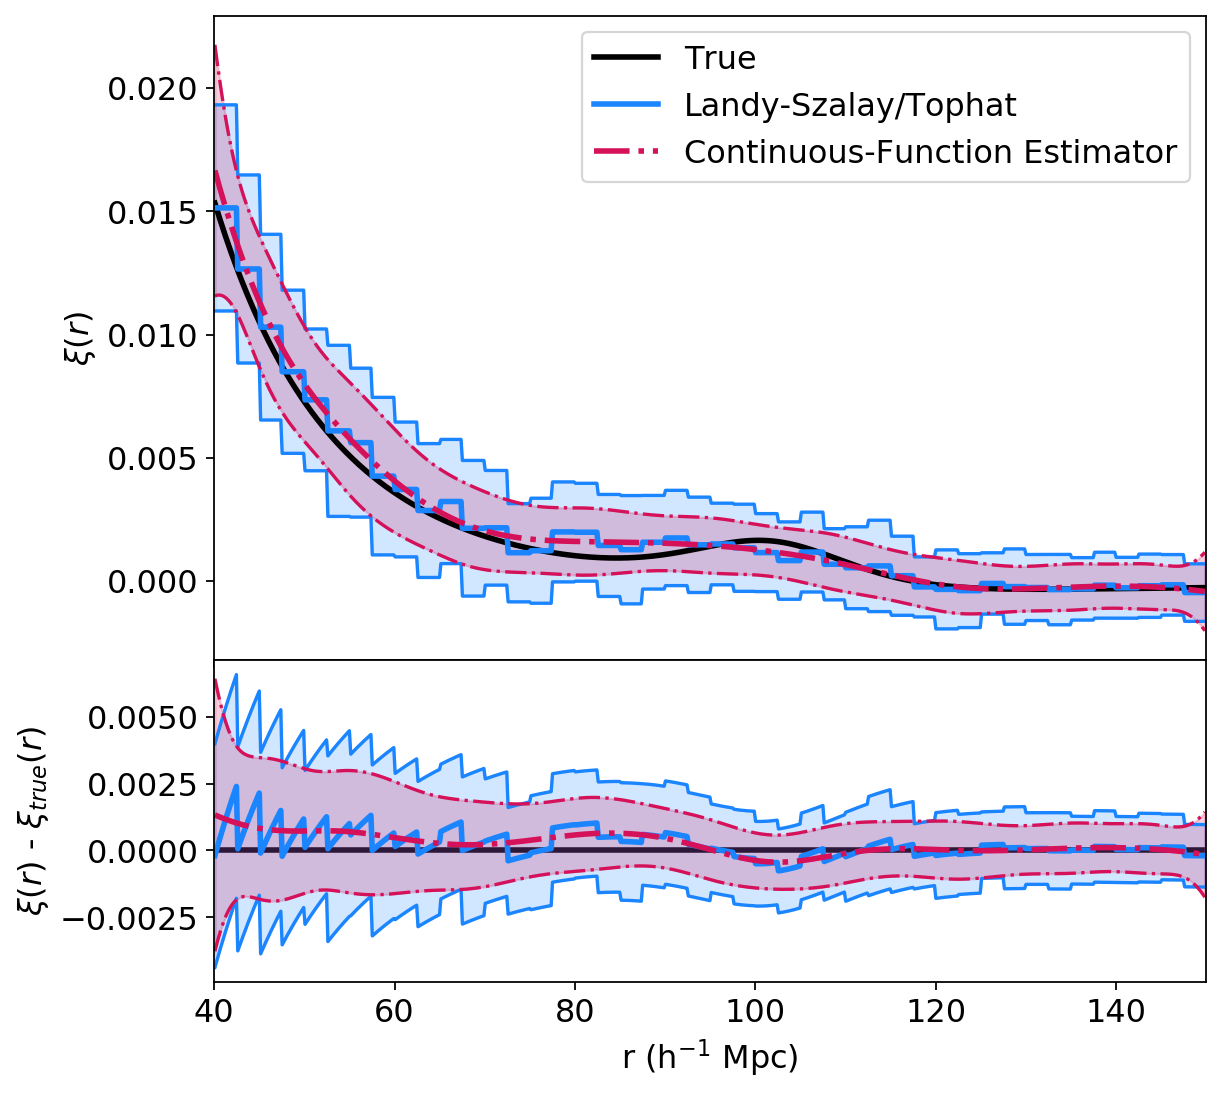

In [41]:
boxsize = 750
nbar_str = '1e-4'
cat_tag = '_L{}_nbar{}'.format(boxsize, nbar_str)
N = 100
seeds = range(N)
result_dir = '../../byebyebias/results/results_lognormal{}'.format(cat_tag)
cat_dir = '../../byebyebias/catalogs/cats_lognormal{}'.format(cat_tag)


#projs = ['tophat', 'quadratic_n10']
projs = ['tophat_n44_cont1000', 'cubic_n11_cont1000']
labels=['Landy-Szalay/Tophat', 'Continuous-Function Estimator']
#colors=[None, 'limegreen']

rmin = 40
rmax = 150
nbins = 44
rbins = np.linspace(rmin, rmax, nbins+1)
#rbins_avg = 0.5*(rbins[1:]+rbins[:-1])

compare_projections_rms(projs, cat_dir, cat_tag, result_dir, rbins, seeds, labels=labels, label_rmse=False)

tophat_n44_cont1000
cubic_n11_cont1000
Landy-Szalay/Tophat RMSE: 4.51e-04
Continuous-Function Estimator RMSE: 3.89e-04


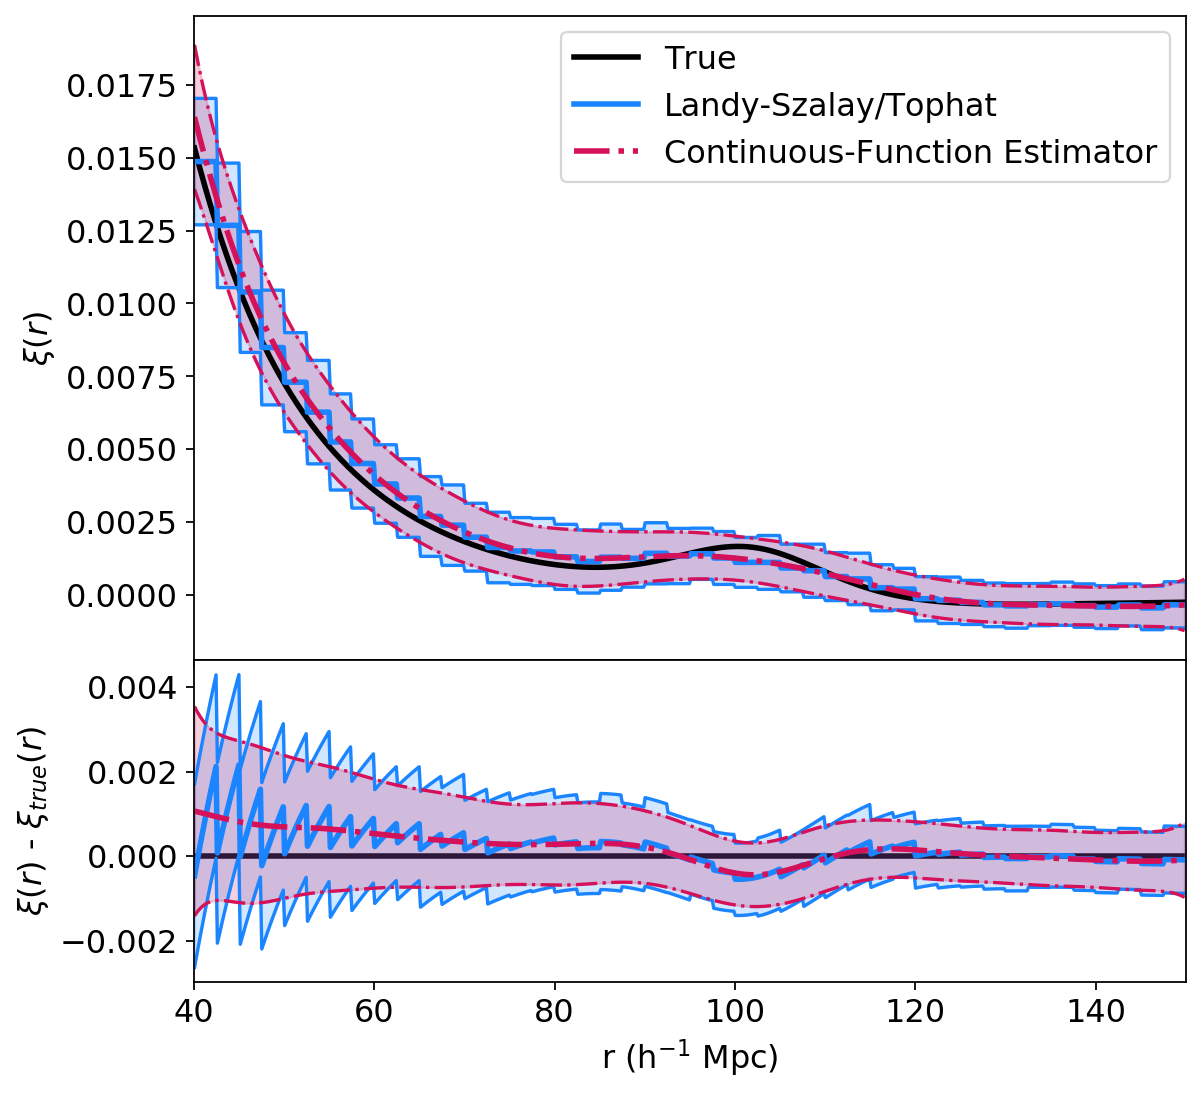

In [42]:
boxsize = 750
nbar_str = '3e-4'
cat_tag = '_L{}_nbar{}'.format(boxsize, nbar_str)
N = 100
seeds = range(N)
result_dir = '../../byebyebias/results/results_lognormal{}'.format(cat_tag)
cat_dir = '../../byebyebias/catalogs/cats_lognormal{}'.format(cat_tag)


#projs = ['tophat', 'quadratic_n10']
projs = ['tophat_n44_cont1000', 'cubic_n11_cont1000']
labels=['Landy-Szalay/Tophat', 'Continuous-Function Estimator']
#colors=[None, 'limegreen']

rmin = 40
rmax = 150
nbins = 44
rbins = np.linspace(rmin, rmax, nbins+1)
#rbins_avg = 0.5*(rbins[1:]+rbins[:-1])

compare_projections_rms(projs, cat_dir, cat_tag, result_dir, rbins, seeds, labels=labels, label_rmse=False)

## Check subsamples

The issue of seems to remain across subsamples, though its strength varies.

tophat_n44_cont1000
cubic_n11_cont1000
Landy-Szalay/Tophat RMSE: 5.24e-04
Continuous-Function Estimator RMSE: 4.71e-04


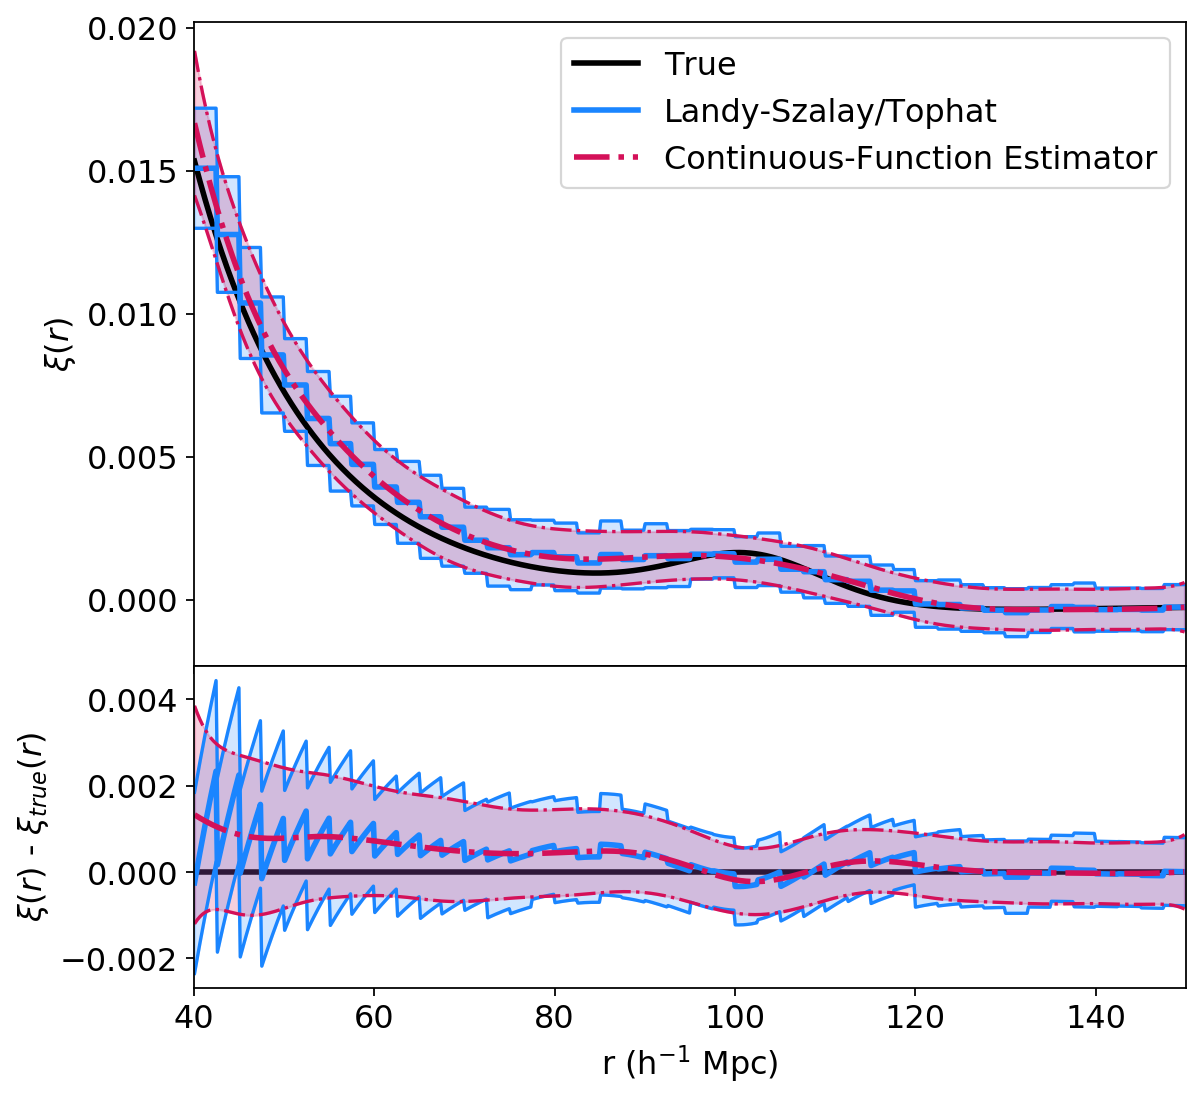

In [35]:
boxsize = 750
nbar_str = '3e-4'
cat_tag = '_L{}_nbar{}'.format(boxsize, nbar_str)
N = 50
seeds = range(N)
result_dir = '../../byebyebias/results/results_lognormal{}'.format(cat_tag)
cat_dir = '../../byebyebias/catalogs/cats_lognormal{}'.format(cat_tag)


#projs = ['tophat', 'quadratic_n10']
projs = ['tophat_n44_cont1000', 'cubic_n11_cont1000']
labels=['Landy-Szalay/Tophat', 'Continuous-Function Estimator']
#colors=[None, 'limegreen']

rmin = 40
rmax = 150
nbins = 44
rbins = np.linspace(rmin, rmax, nbins+1)
#rbins_avg = 0.5*(rbins[1:]+rbins[:-1])

compare_projections_rms(projs, cat_dir, cat_tag, result_dir, rbins, seeds, labels=labels, label_rmse=False)

tophat_n44_cont1000
cubic_n11_cont1000
Landy-Szalay/Tophat RMSE: 4.26e-04
Continuous-Function Estimator RMSE: 3.52e-04


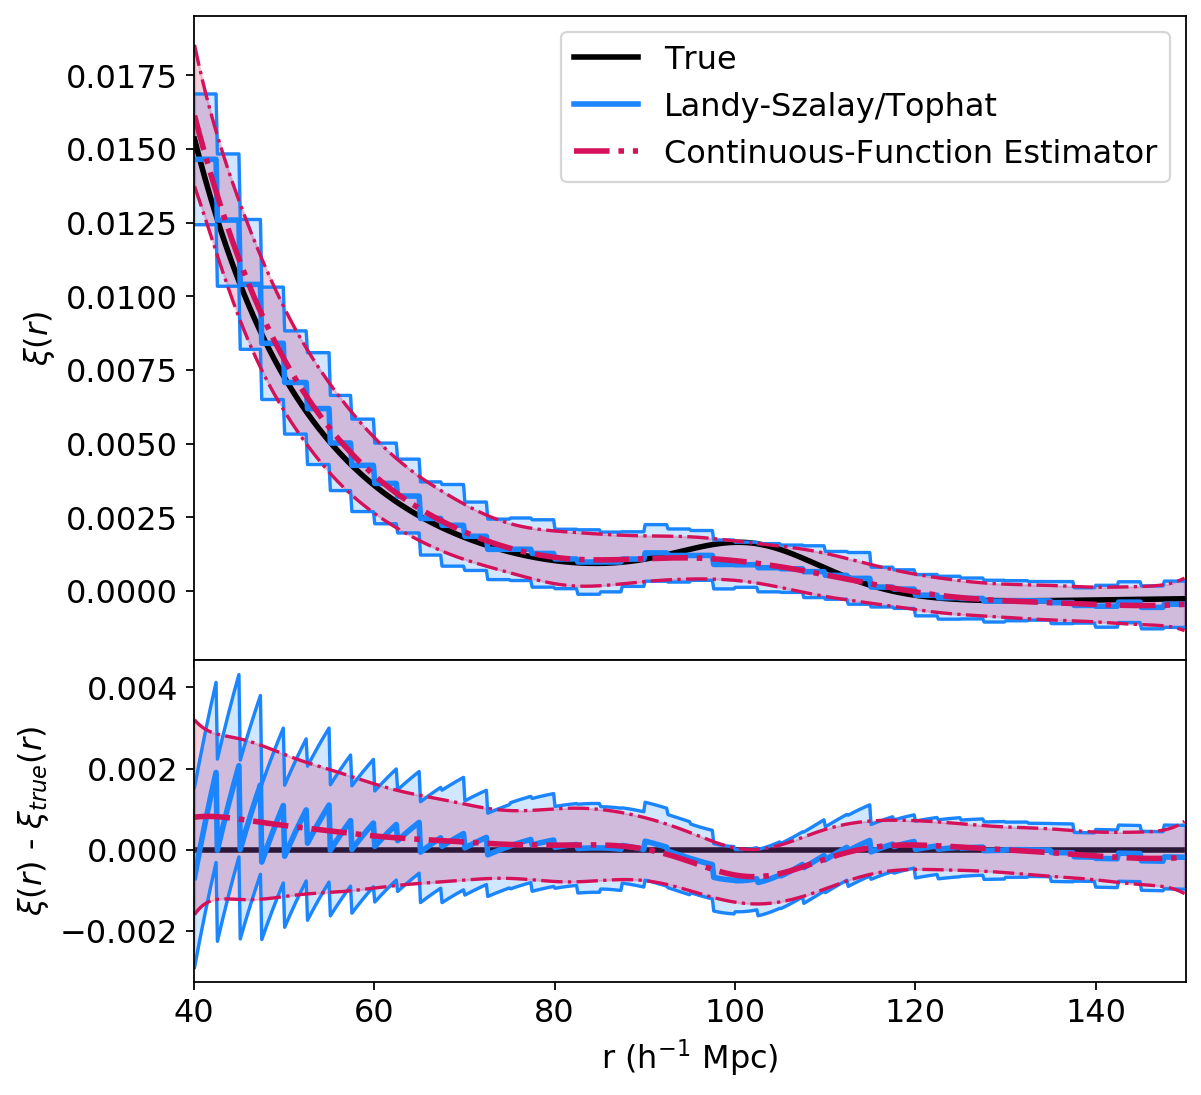

In [34]:
boxsize = 750
nbar_str = '3e-4'
cat_tag = '_L{}_nbar{}'.format(boxsize, nbar_str)
N = 50
seeds = range(N, N+50)
result_dir = '../../byebyebias/results/results_lognormal{}'.format(cat_tag)
cat_dir = '../../byebyebias/catalogs/cats_lognormal{}'.format(cat_tag)


#projs = ['tophat', 'quadratic_n10']
projs = ['tophat_n44_cont1000', 'cubic_n11_cont1000']
labels=['Landy-Szalay/Tophat', 'Continuous-Function Estimator']
#colors=[None, 'limegreen']

rmin = 40
rmax = 150
nbins = 44
rbins = np.linspace(rmin, rmax, nbins+1)
#rbins_avg = 0.5*(rbins[1:]+rbins[:-1])

compare_projections_rms(projs, cat_dir, cat_tag, result_dir, rbins, seeds, labels=labels, label_rmse=False)

tophat_n44_cont1000
cubic_n11_cont1000
Landy-Szalay/Tophat RMSE: 5.92e-04
Continuous-Function Estimator RMSE: 5.41e-04


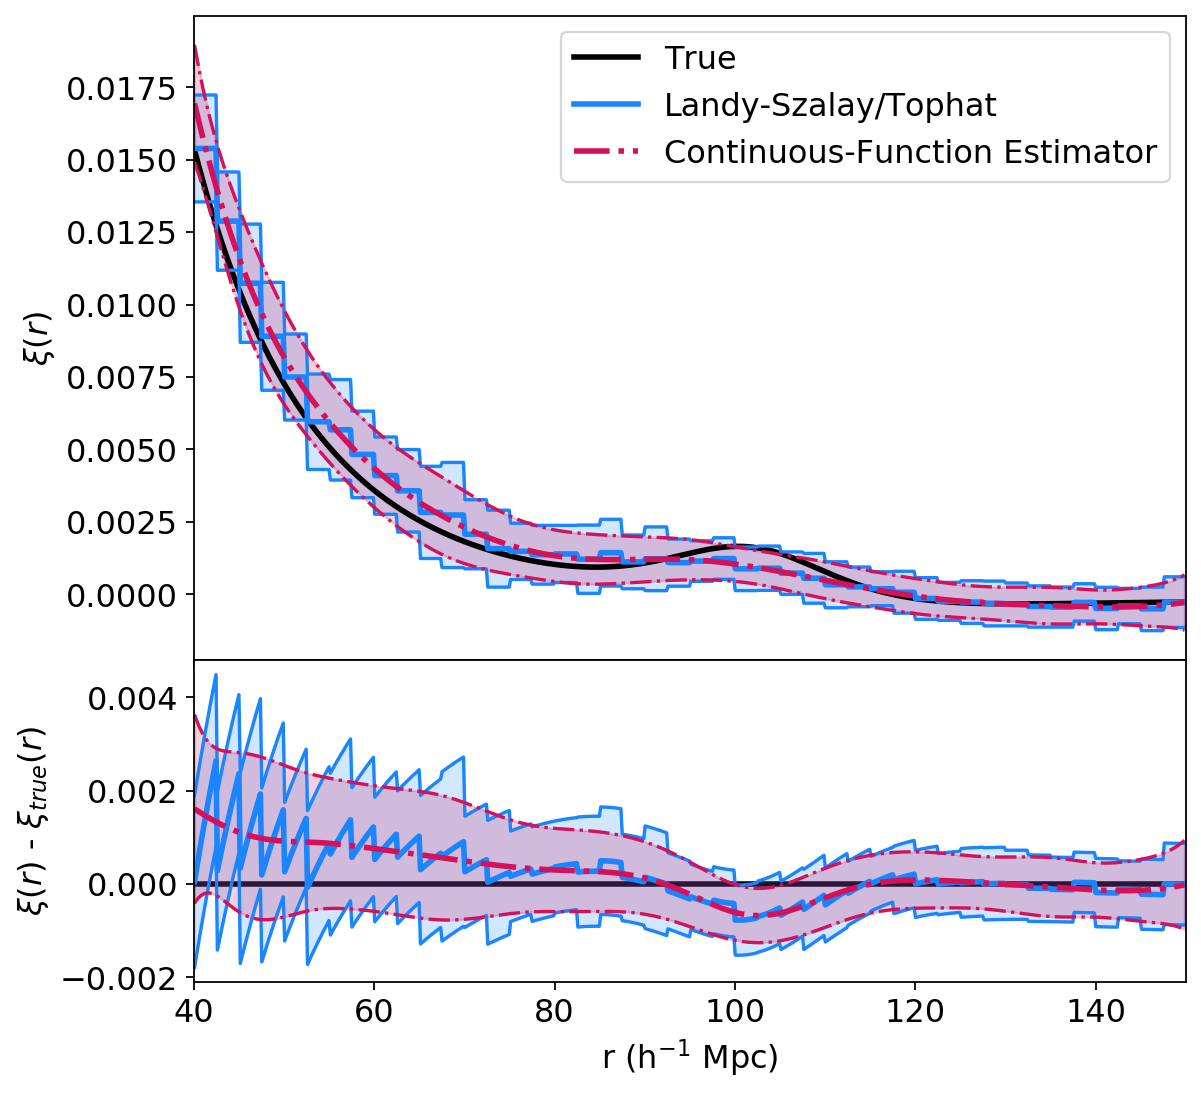

In [46]:
boxsize = 750
nbar_str = '3e-4'
cat_tag = '_L{}_nbar{}'.format(boxsize, nbar_str)
N = 25
seeds = np.random.randint(100, size=N)
result_dir = '../../byebyebias/results/results_lognormal{}'.format(cat_tag)
cat_dir = '../../byebyebias/catalogs/cats_lognormal{}'.format(cat_tag)


#projs = ['tophat', 'quadratic_n10']
projs = ['tophat_n44_cont1000', 'cubic_n11_cont1000']
labels=['Landy-Szalay/Tophat', 'Continuous-Function Estimator']
#colors=[None, 'limegreen']

rmin = 40
rmax = 150
nbins = 44
rbins = np.linspace(rmin, rmax, nbins+1)
#rbins_avg = 0.5*(rbins[1:]+rbins[:-1])

compare_projections_rms(projs, cat_dir, cat_tag, result_dir, rbins, seeds, labels=labels, label_rmse=False)

tophat_n44_cont1000
cubic_n11_cont1000
Landy-Szalay/Tophat RMSE: 6.54e-04
Continuous-Function Estimator RMSE: 5.85e-04


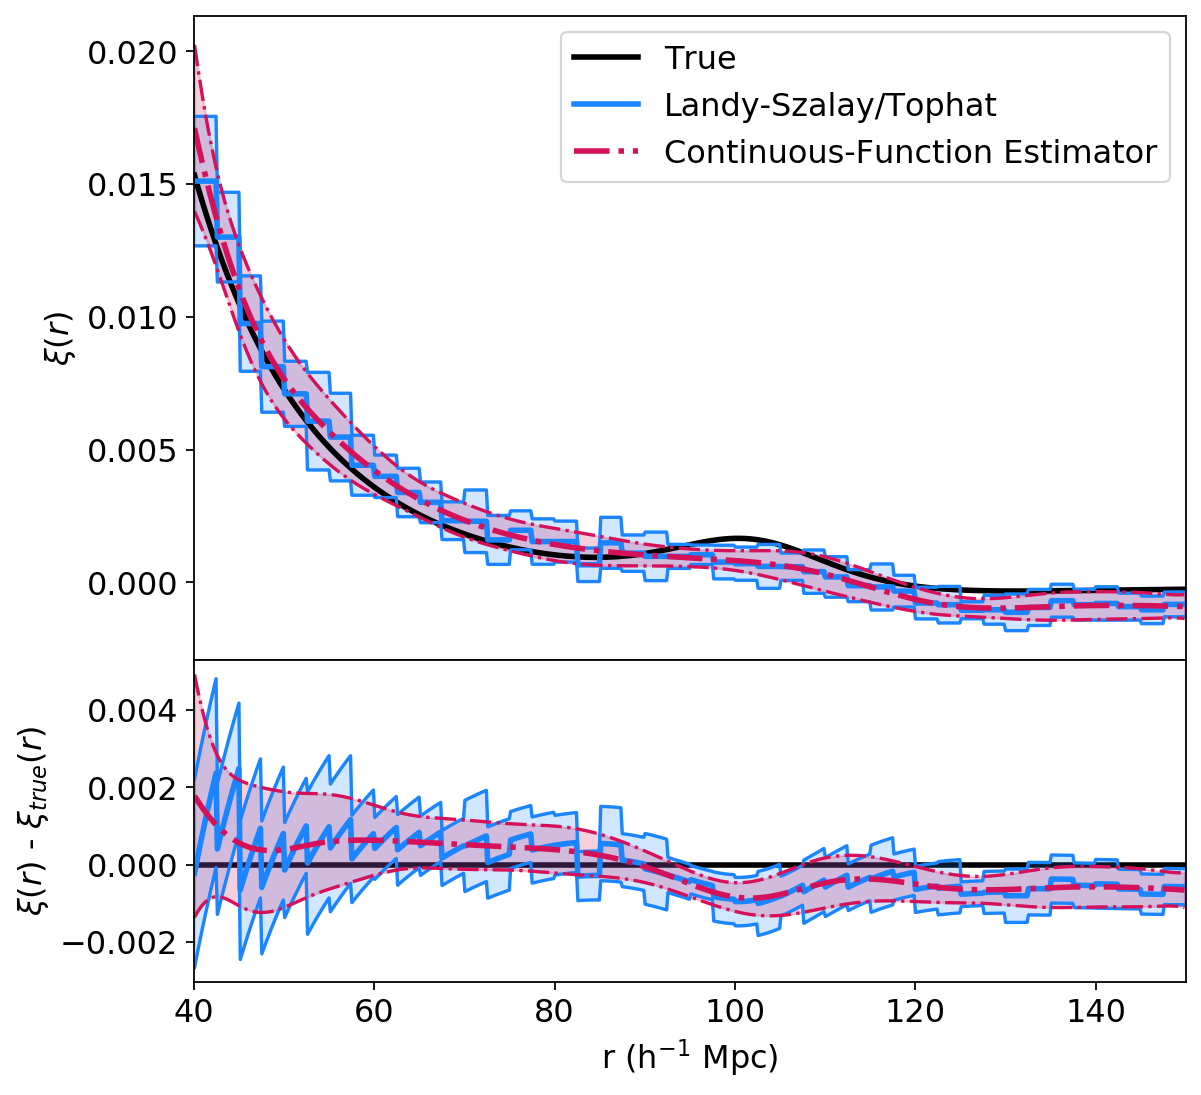

In [10]:
boxsize = 750
nbar_str = '3e-4'
cat_tag = '_L{}_nbar{}'.format(boxsize, nbar_str)
N = 10
seeds = np.random.randint(100, size=N)
result_dir = '../../byebyebias/results/results_lognormal{}'.format(cat_tag)
cat_dir = '../../byebyebias/catalogs/cats_lognormal{}'.format(cat_tag)


#projs = ['tophat', 'quadratic_n10']
projs = ['tophat_n44_cont1000', 'cubic_n11_cont1000']
labels=['Landy-Szalay/Tophat', 'Continuous-Function Estimator']
#colors=[None, 'limegreen']

rmin = 40
rmax = 150
nbins = 44
rbins = np.linspace(rmin, rmax, nbins+1)
#rbins_avg = 0.5*(rbins[1:]+rbins[:-1])

compare_projections_rms(projs, cat_dir, cat_tag, result_dir, rbins, seeds, labels=labels, label_rmse=False)

standard
(1, 22)
rmse: False
plotting
(100, 22)
rmse: False
plotting


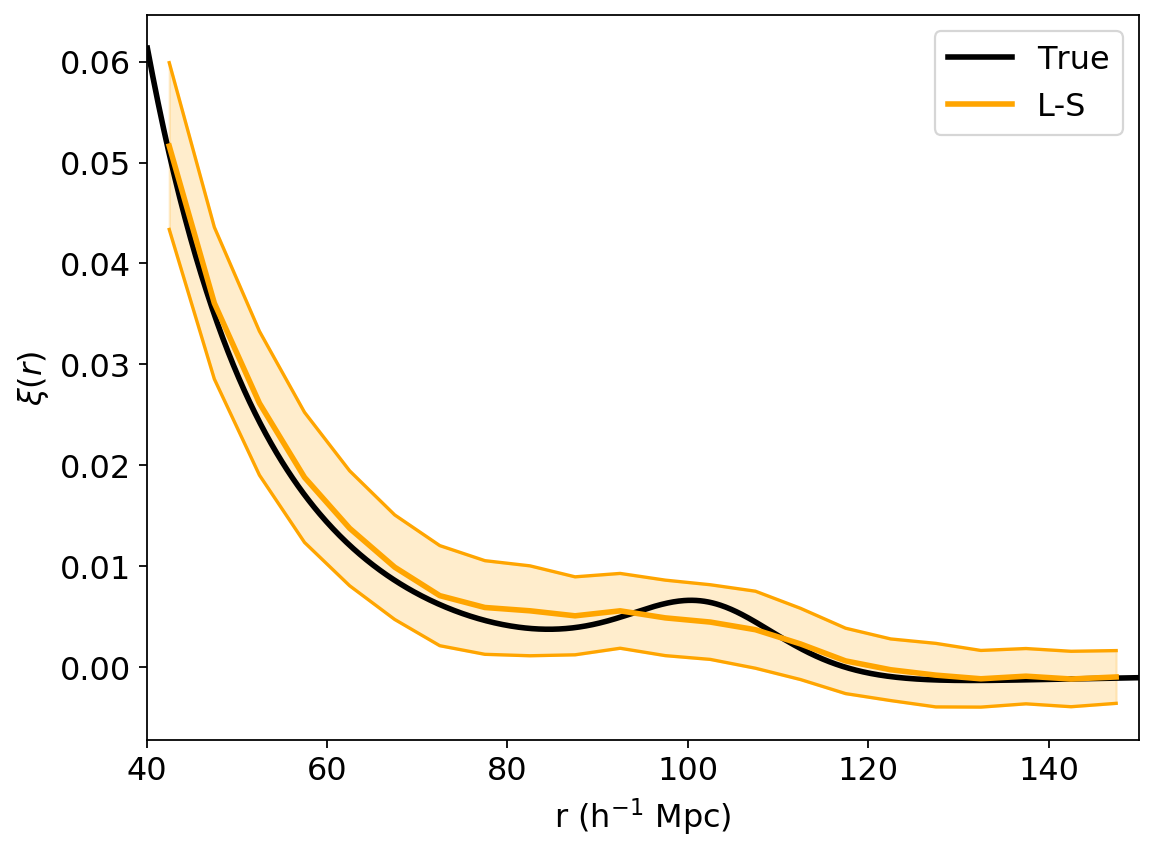

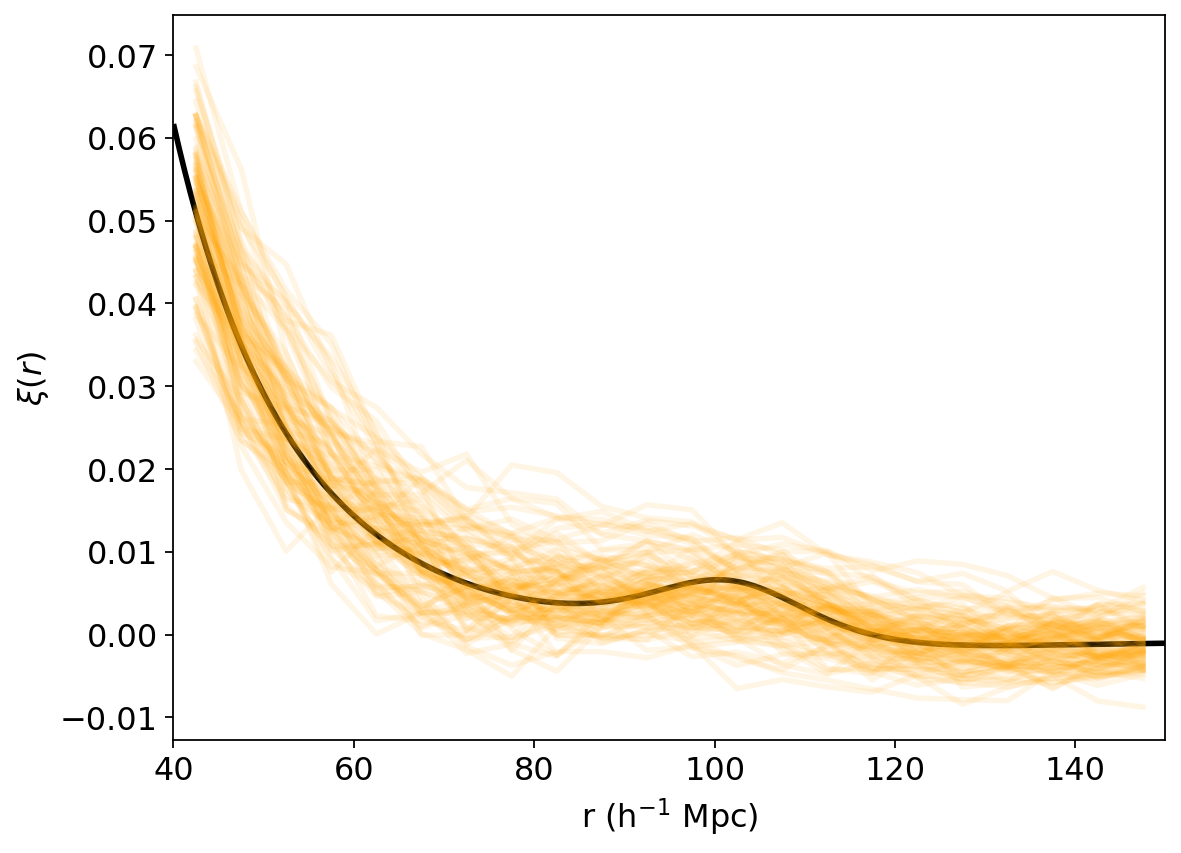

In [26]:
boxsize = 750
nbar_str = '1e-4'
b1 = 2
mock_tag = '_b{}'.format(b1)
cat_tag = '_L{}_nbar{}{}'.format(boxsize, nbar_str, mock_tag)
N = 100
seeds = range(N)
result_dir = '../../byebyebias/results/results_lognormal{}'.format(cat_tag)
cat_dir = '../../byebyebias/catalogs/cats_lognormal{}'.format(cat_tag)


#projs = ['tophat', 'quadratic_n10']
projs = ['standard']
labels = ['L-S']*N
#labels=['Landy-Szalay/Tophat', 'Continuous-Function Estimator']
#colors=[None, 'limegreen']
colors = ['orange']*N

rmin = 40
rmax = 150
nbins = 44
rbins = np.linspace(rmin, rmax, nbins+1)
#rbins_avg = 0.5*(rbins[1:]+rbins[:-1])

compare_projections_rms(projs, cat_dir, cat_tag, result_dir, rbins, seeds, labels=labels, colors=colors, label_rmse=False, b1=b1)

standard
(1, 22)
rmse: False
plotting
(100, 22)
rmse: False
plotting


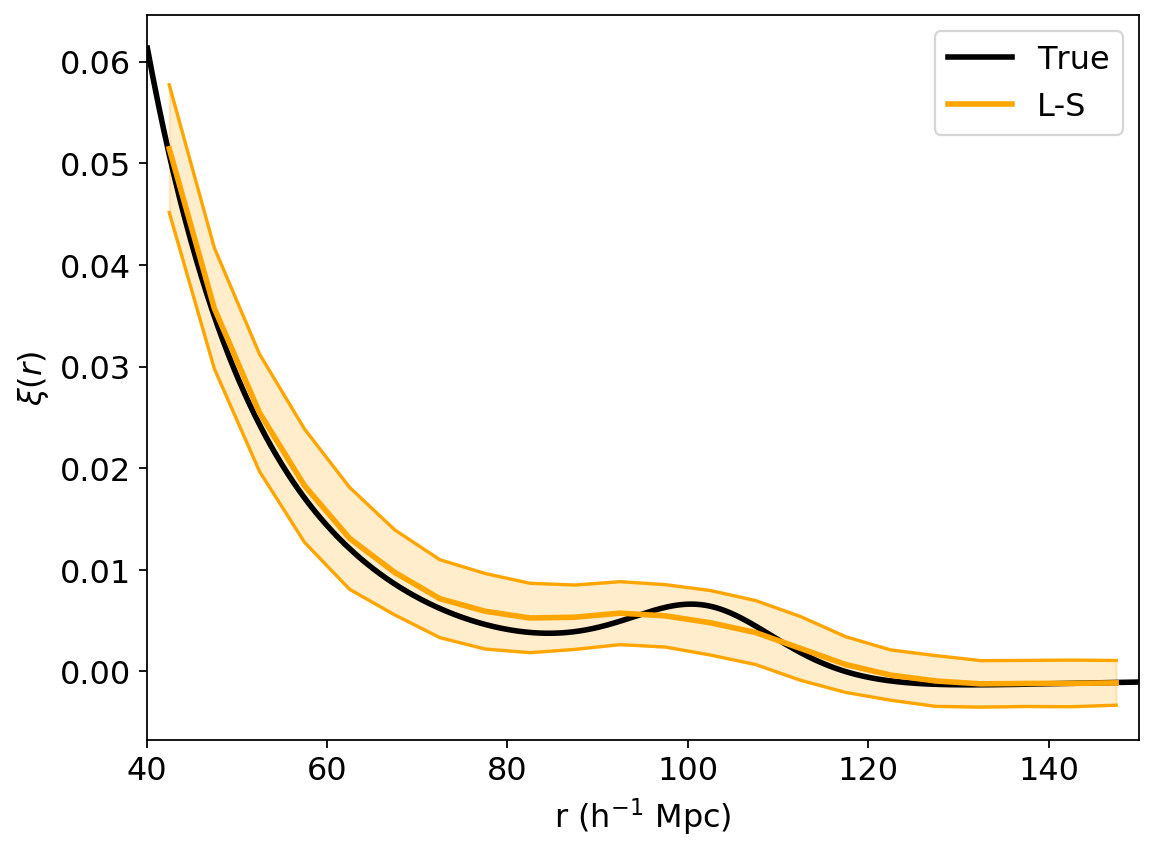

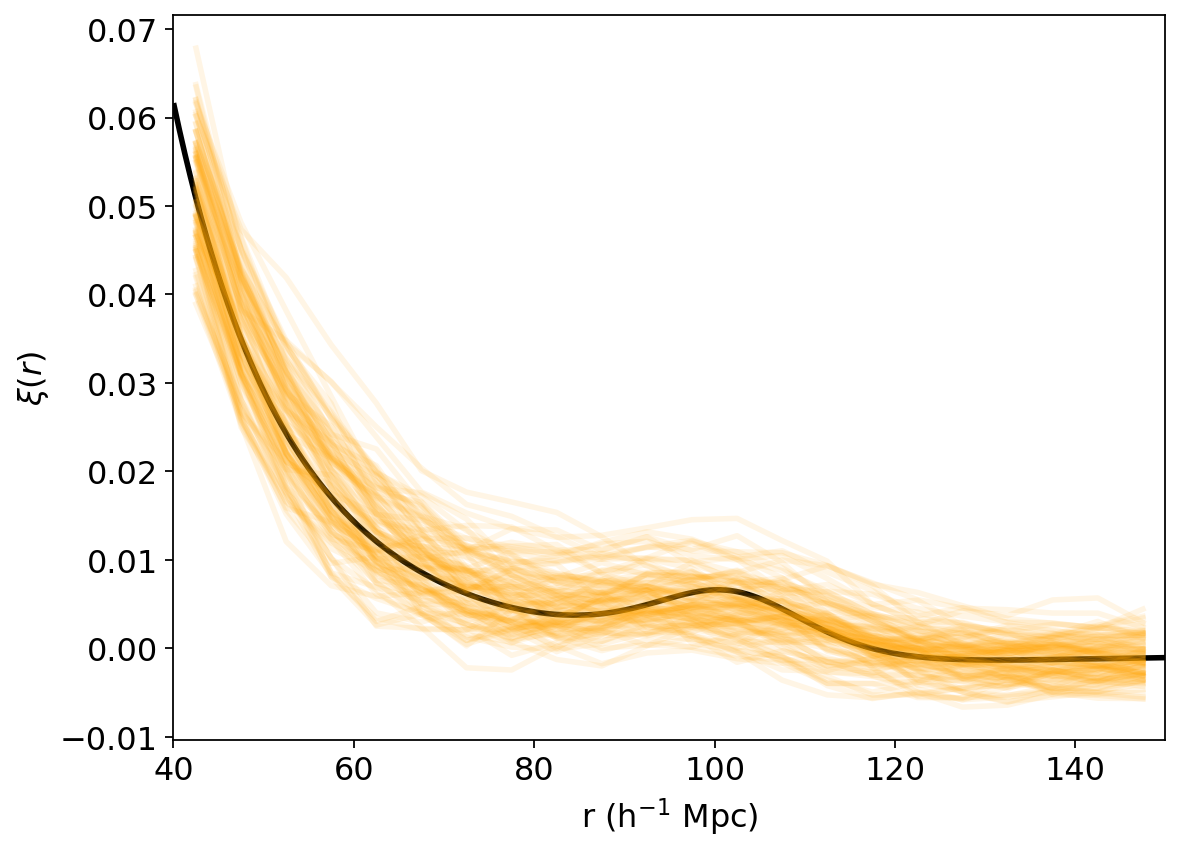

In [24]:
boxsize = 750
nbar_str = '3e-4'
b1 = 2
mock_tag = '_b{}'.format(b1)
cat_tag = '_L{}_nbar{}{}'.format(boxsize, nbar_str, mock_tag)
N = 100
seeds = range(N)
result_dir = '../../byebyebias/results/results_lognormal{}'.format(cat_tag)
cat_dir = '../../byebyebias/catalogs/cats_lognormal{}'.format(cat_tag)


#projs = ['tophat', 'quadratic_n10']
projs = ['standard']
labels = ['L-S']*N
#labels=['Landy-Szalay/Tophat', 'Continuous-Function Estimator']
#colors=[None, 'limegreen']
colors = ['orange']*N

rmin = 40
rmax = 150
nbins = 44
rbins = np.linspace(rmin, rmax, nbins+1)
#rbins_avg = 0.5*(rbins[1:]+rbins[:-1])

compare_projections_rms(projs, cat_dir, cat_tag, result_dir, rbins, seeds, labels=labels, colors=colors, label_rmse=False, b1=b1)

standard
(1, 22)
rmse: False
plotting
(1, 22)
rmse: False
plotting


/home/users/ksf293/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/users/ksf293/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


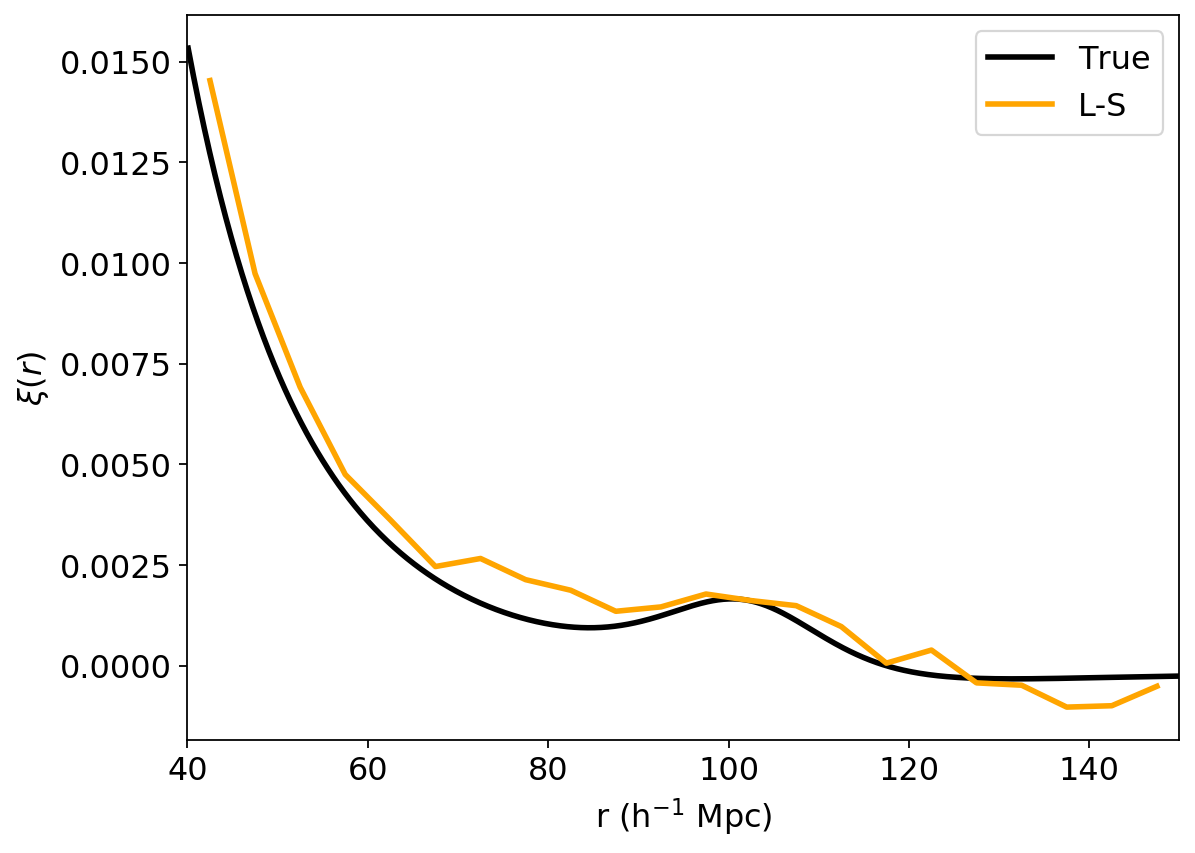

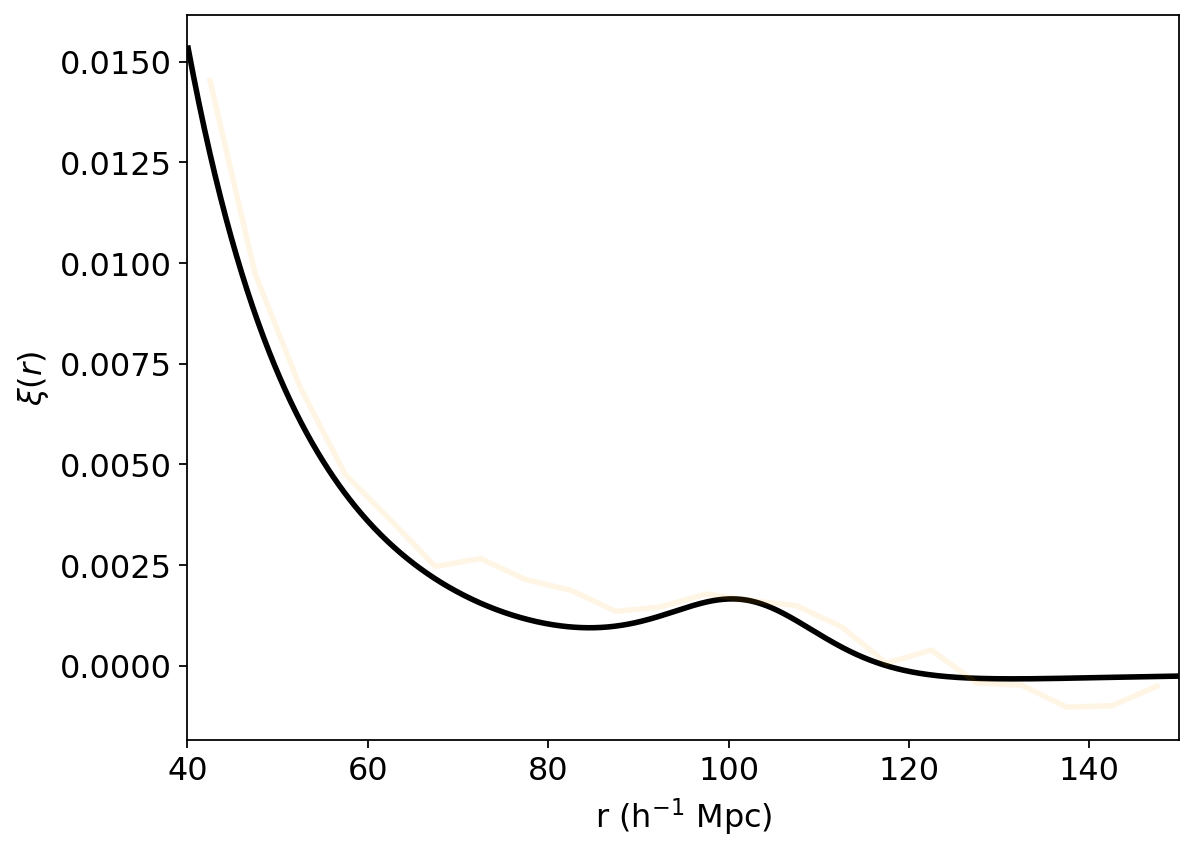

In [10]:
boxsize = 1000
nbar_str = '3e-4'
#b1 = 1.0
#mock_tag = '_b{}'.format(b1)
mock_tag = ''
cat_tag = '_L{}_nbar{}{}'.format(boxsize, nbar_str, mock_tag)
N = 1
seeds = range(N)
result_dir = '../../byebyebias/results/results_lognormal{}'.format(cat_tag)
cat_dir = '../../byebyebias/catalogs/cats_lognormal{}'.format(cat_tag)


#projs = ['tophat', 'quadratic_n10']
projs = ['standard']
labels = ['L-S']*N
#labels=['Landy-Szalay/Tophat', 'Continuous-Function Estimator']
#colors=[None, 'limegreen']
colors = ['orange']*N

rmin = 40
rmax = 150
nbins = 44
rbins = np.linspace(rmin, rmax, nbins+1)
#rbins_avg = 0.5*(rbins[1:]+rbins[:-1])

compare_projections_rms(projs, cat_dir, cat_tag, result_dir, rbins, seeds, labels=labels, colors=colors, label_rmse=False, b1=b1)

standard
(1, 22)
rmse: False
plotting
(1, 22)
rmse: False
plotting


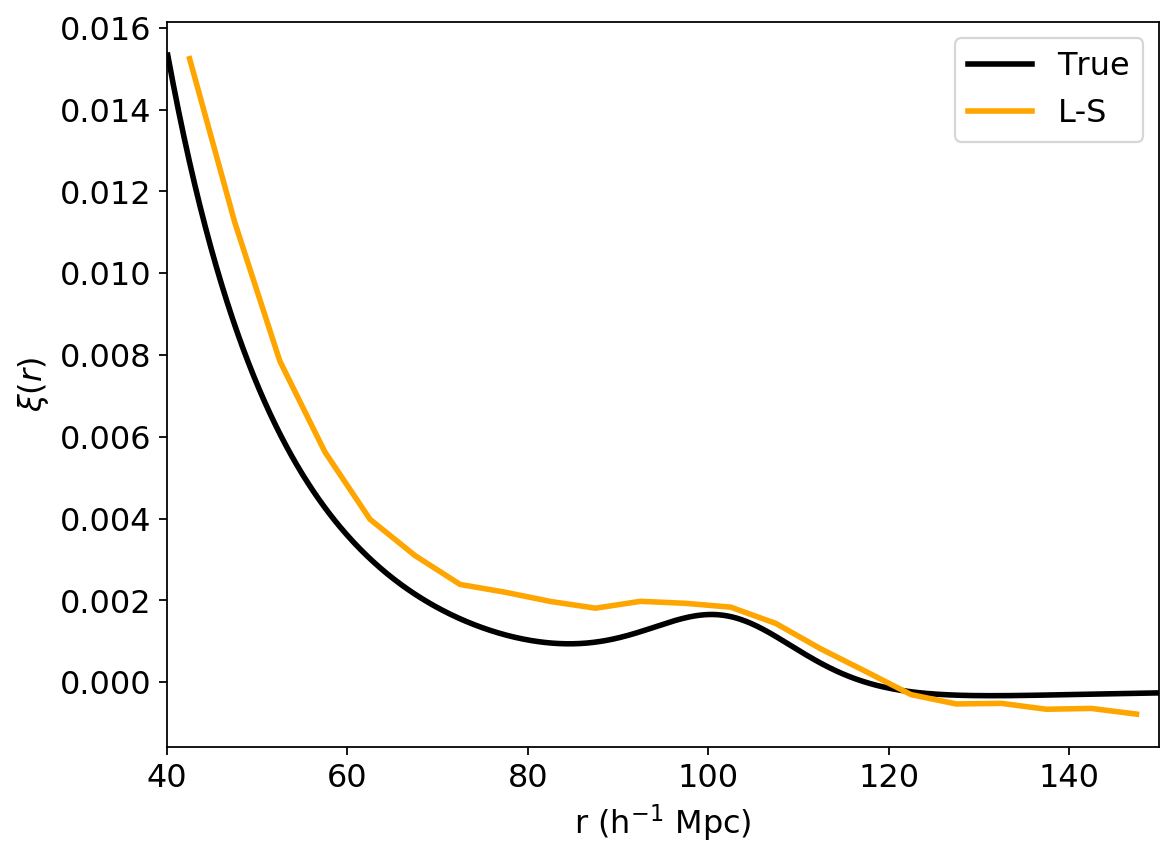

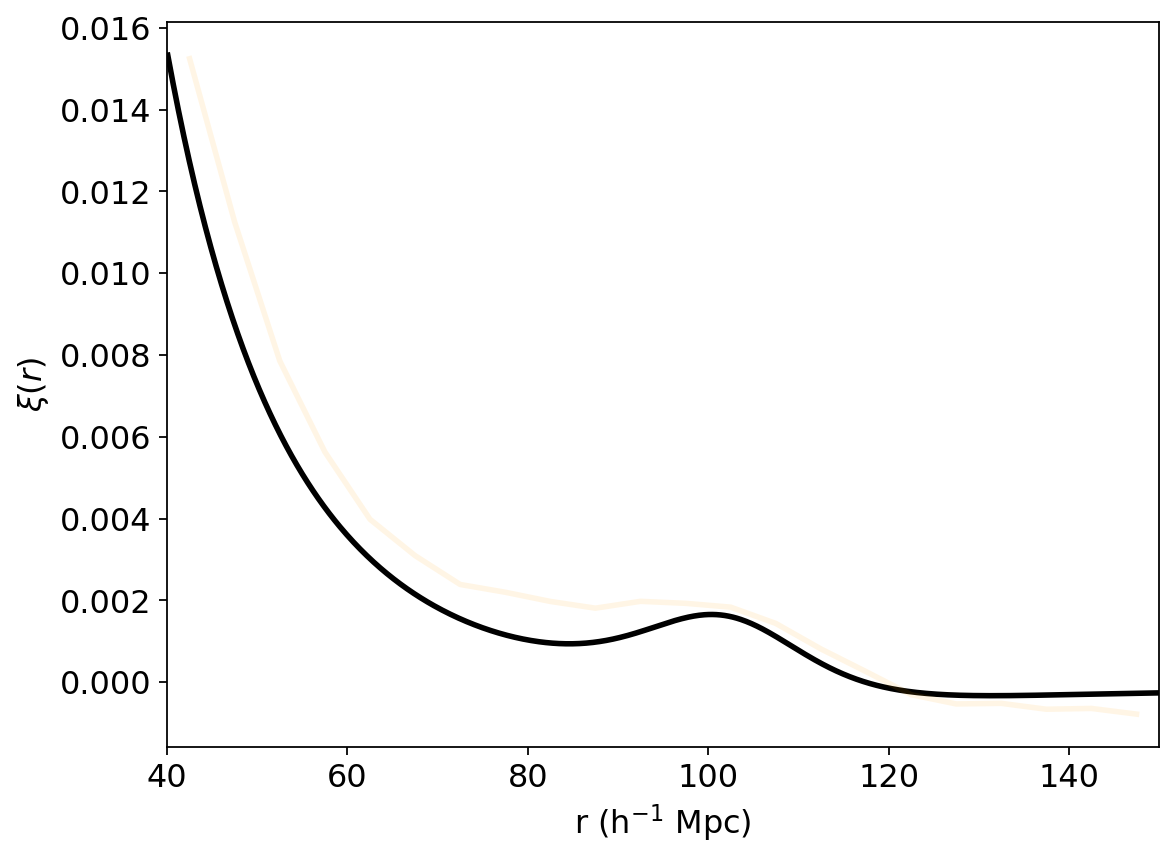

In [11]:
boxsize = 1000
nbar_str = '1e-3'
#b1 = 1.0
#mock_tag = '_b{}'.format(b1)
mock_tag = ''
cat_tag = '_L{}_nbar{}{}'.format(boxsize, nbar_str, mock_tag)
N = 1
seeds = range(N)
result_dir = '../../byebyebias/results/results_lognormal{}'.format(cat_tag)
cat_dir = '../../byebyebias/catalogs/cats_lognormal{}'.format(cat_tag)


#projs = ['tophat', 'quadratic_n10']
projs = ['standard']
labels = ['L-S']*N
#labels=['Landy-Szalay/Tophat', 'Continuous-Function Estimator']
#colors=[None, 'limegreen']
colors = ['orange']*N

rmin = 40
rmax = 150
nbins = 44
rbins = np.linspace(rmin, rmax, nbins+1)
#rbins_avg = 0.5*(rbins[1:]+rbins[:-1])

compare_projections_rms(projs, cat_dir, cat_tag, result_dir, rbins, seeds, labels=labels, colors=colors, label_rmse=False, b1=b1)

theory
(1, 32)
rmse: False
plotting
(1, 32)
rmse: False
plotting


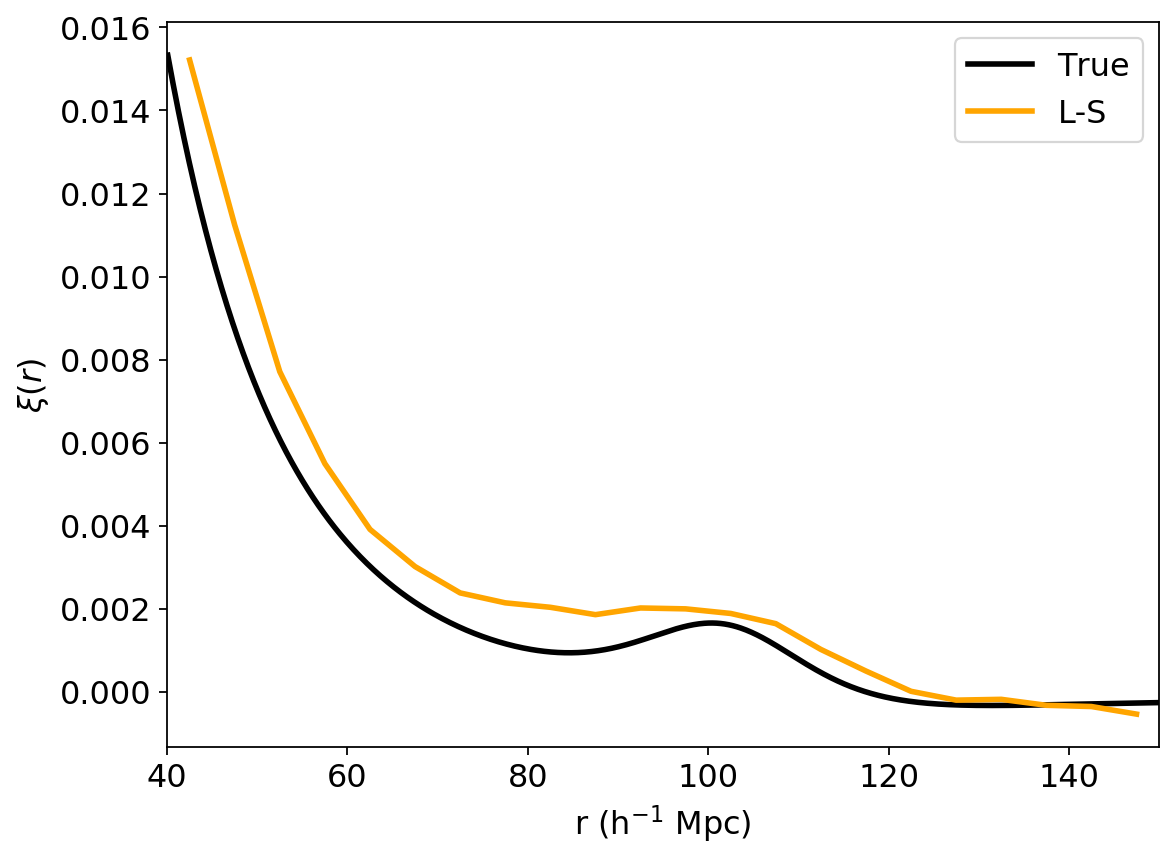

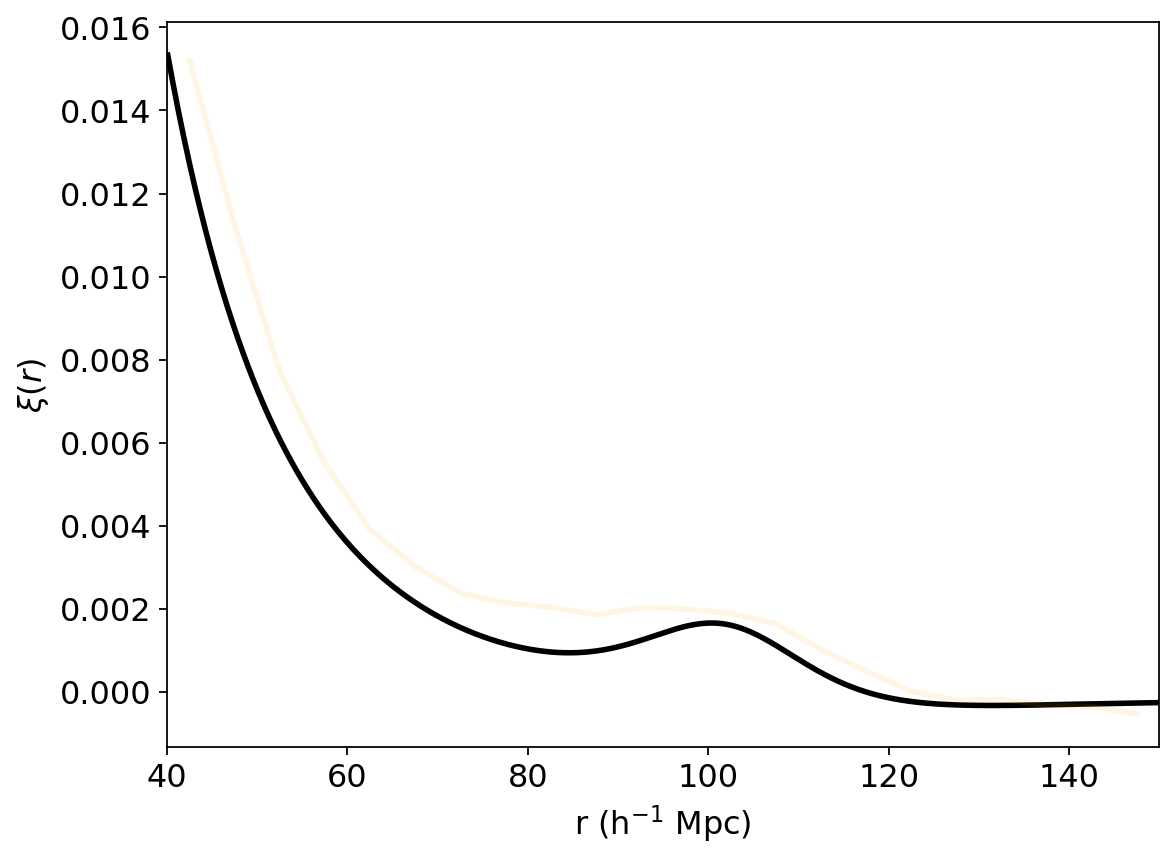

In [14]:
boxsize = 1000
nbar_str = '1e-3'
#b1 = 1.0
#mock_tag = '_b{}'.format(b1)
mock_tag = ''
cat_tag = '_L{}_nbar{}{}'.format(boxsize, nbar_str, mock_tag)
N = 1
seeds = range(N)
result_dir = '../../byebyebias/results/results_lognormal{}'.format(cat_tag)
cat_dir = '../../byebyebias/catalogs/cats_lognormal{}'.format(cat_tag)


#projs = ['tophat', 'quadratic_n10']
projs = ['theory']
labels = ['L-S']*N
#labels=['Landy-Szalay/Tophat', 'Continuous-Function Estimator']
#colors=[None, 'limegreen']
colors = ['orange']*N

rmin = 40
rmax = 150
nbins = 44
rbins = np.linspace(rmin, rmax, nbins+1)
#rbins_avg = 0.5*(rbins[1:]+rbins[:-1])

compare_projections_rms(projs, cat_dir, cat_tag, result_dir, rbins, seeds, labels=labels, colors=colors, label_rmse=False, b1=b1)

(-0.0006616401073572531, 0.015215917762863684)

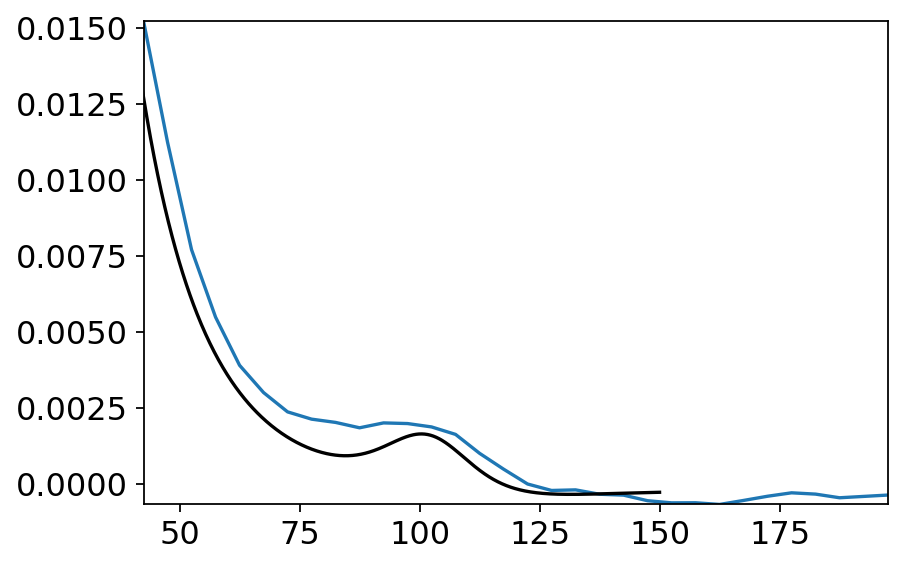

In [16]:
boxsize = 1000
nbar_str = '1e-3'
mock_tag = ''
cat_tag = '_L{}_nbar{}{}'.format(boxsize, nbar_str, mock_tag)
seed = 0

result_dir = '../../byebyebias/results/results_lognormal{}'.format(cat_tag)
cat_dir = '../../byebyebias/catalogs/cats_lognormal{}'.format(cat_tag)

cf_fn = '{}/cf_lin_{}{}.npy'.format(result_dir, 'theory', cat_tag)
r_avg, xi, label = np.load(cf_fn, allow_pickle=True)

# true
#true_fn = '{}/inputs/{}_Rh_xi.txt'.format(cat_dir, cat_tag)
#r_true, xi_true = np.loadtxt(true_fn, unpack=True)
b1 = 1.0
conttag = '_cont1000'   
r_true, xi_true, _ = np.load('{}/cf_lin_true{}{}.npy'.format(cat_dir, conttag, cat_tag), allow_pickle=True)

plt.plot(r_avg, xi)
plt.plot(r_true, xi_true*b1**2, color='k')
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(min(r_avg), max(r_avg))
plt.ylim(min(xi), max(xi))
#plt.xlim(min(r_avg), max(r_avg))
#plt.ylim(min(xi), max(xi))

(-0.0016172716807852927, 0.031202101163838147)

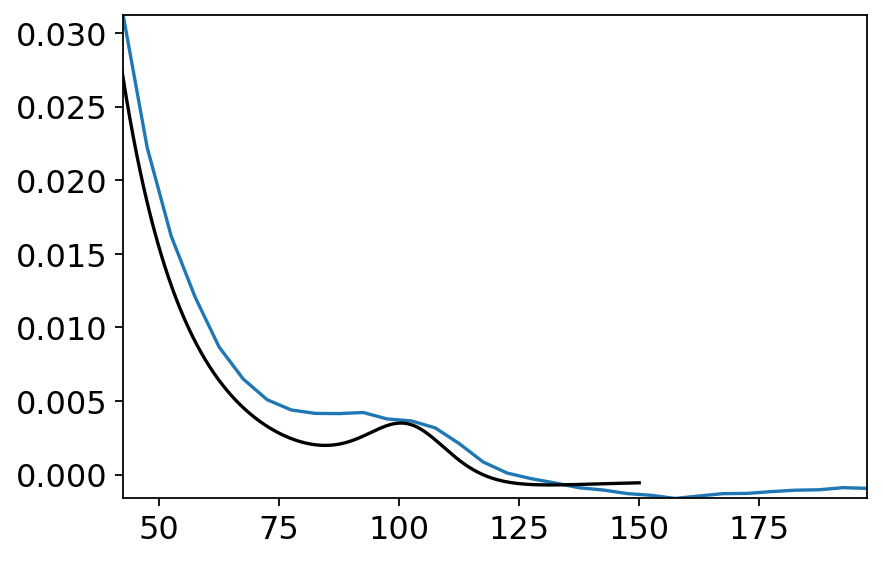

In [18]:
boxsize = 1000
nbar_str = '1e-3'
mock_tag = '_b1455'
cat_tag = '_L{}_nbar{}{}'.format(boxsize, nbar_str, mock_tag)
seed = 0

result_dir = '../../byebyebias/results/results_lognormal{}'.format(cat_tag)
cat_dir = '../../byebyebias/catalogs/cats_lognormal{}'.format(cat_tag)

cf_fn = '{}/cf_lin_{}{}_seed{}.npy'.format(result_dir, 'theory', cat_tag, seed)
r_avg, xi, label = np.load(cf_fn, allow_pickle=True)

# true
#true_fn = '{}/inputs/{}_Rh_xi.txt'.format(cat_dir, cat_tag)
#r_true, xi_true = np.loadtxt(true_fn, unpack=True)
b1 = 1.455
conttag = '_cont1000'   
r_true, xi_true, _ = np.load('{}/cf_lin_true{}{}.npy'.format(cat_dir, conttag, cat_tag), allow_pickle=True)

plt.plot(r_avg, xi)
plt.plot(r_true, xi_true*b1**2, color='k')
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(min(r_avg), max(r_avg))
plt.ylim(min(xi), max(xi))
#plt.xlim(min(r_avg), max(r_avg))
#plt.ylim(min(xi), max(xi))

(-0.0014779576386984017, 0.03143910350937129)

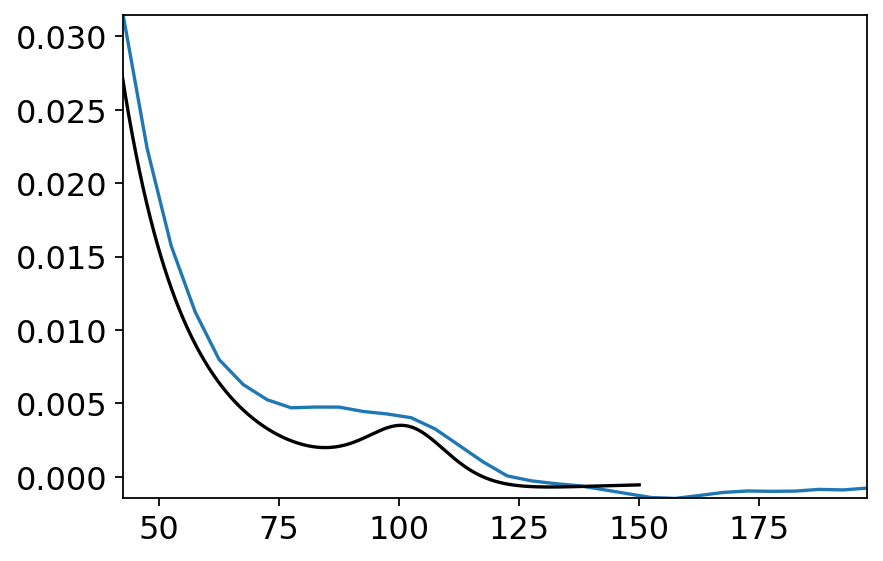

In [19]:
boxsize = 1000
nbar_str = '1e-3'
mock_tag = '_b1455_Nmesh512'
cat_tag = '_L{}_nbar{}{}'.format(boxsize, nbar_str, mock_tag)
seed = 0

result_dir = '../../byebyebias/results/results_lognormal{}'.format(cat_tag)
cat_dir = '../../byebyebias/catalogs/cats_lognormal{}'.format(cat_tag)

cf_fn = '{}/cf_lin_{}{}_seed{}.npy'.format(result_dir, 'theory', cat_tag, seed)
r_avg, xi, label = np.load(cf_fn, allow_pickle=True)

# true
#true_fn = '{}/inputs/{}_Rh_xi.txt'.format(cat_dir, cat_tag)
#r_true, xi_true = np.loadtxt(true_fn, unpack=True)
b1 = 1.455
conttag = '_cont1000'   
r_true, xi_true, _ = np.load('{}/cf_lin_true{}{}.npy'.format(cat_dir, conttag, cat_tag), allow_pickle=True)

plt.plot(r_avg, xi)
plt.plot(r_true, xi_true*b1**2, color='k')
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(min(r_avg), max(r_avg))
plt.ylim(min(xi), max(xi))
#plt.xlim(min(r_avg), max(r_avg))
#plt.ylim(min(xi), max(xi))